Importing necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import keras_tuner as kt
import tensorflow as tf

Loading a database

In [2]:
train_db = pd.read_csv(r'datasets/train.csv', sep=';')
test_db = pd.read_csv(r'datasets/test.csv', sep=';')
evaluation_db = pd.read_csv(r'datasets/evaluation.csv', sep=';')

In [3]:
db = pd.concat([train_db, test_db, evaluation_db], ignore_index=True) #deleting indexes and creating new one to prevent any mistakes
db = db.drop(['Unnamed: 0'], axis=1)  #deleting the column with the indexes
db = db.drop_duplicates()
db['text'] = db['text'].str.lower()
db['title'] = db['title'].str.lower()

Preliminary database analysis

In [4]:
db.head()

,title,text,label
0,palestinians switch off christmas lights in be...,"ramallah, west bank (reuters) - palestinians s...",1
1,china says trump call with taiwan president wo...,beijing (reuters) - u.s. president-elect donal...,1
2,fail! the trump organization’s credit score w...,while the controversy over trump s personal ta...,0
3,zimbabwe military chief's china trip was norma...,beijing (reuters) - a trip to beijing last wee...,1
4,the most uncourageous president ever receives ...,there has never been a more uncourageous perso...,0


In [5]:
db.shape

(40586, 3)

In [6]:
db.dtypes

title    object
text     object
label     int64
dtype: object

In [7]:
db.nunique() #the number of unique values

title    39995
text     40585
label        2
dtype: int64

In [8]:
db.label.value_counts() 

label
1    21924
0    18662
Name: count, dtype: int64

In [9]:
db.isna().sum() #identifying the amount of missing values

title    0
text     0
label    0
dtype: int64

In [10]:
max_text = max(len(text) for text in db['text'])
max_title = max(len(title) for title in db['title'])

print('The longest text has', max_text, 'characters')
print('The longest title has', max_title, 'characters')

The longest text has 51793 characters
The longest title has 443 characters


In [11]:
#We can see that our database contains 3 columns - title, text and label - and a newly created index
#Databse has 40586 records from which there are 39995 unique titles, 40585 unique texts and 2 unique  labels
#There are total of 21924 true articles (1) and 18662 fake news (0)
#The longest text in the database has 51793 characters and the longest title has 443 character

Division of Real and Fake News

In [12]:
#preparing values for a graph
labels = ["0 - Fake News","1 - Real News"]
values = db['label'].value_counts()
colors = ['#5c97e6','#ed5e4e']

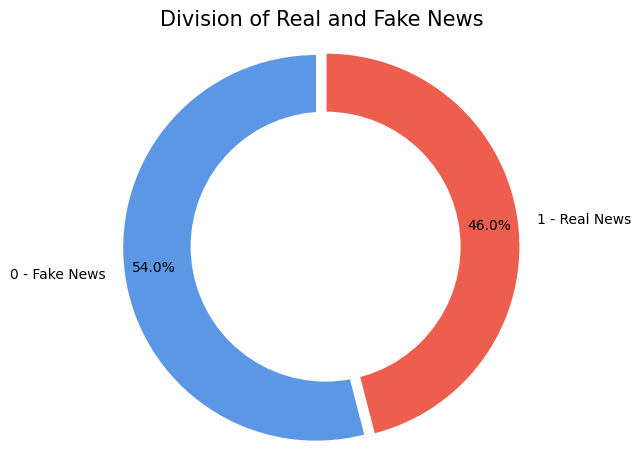

In [13]:
fig1, ax1 = plt.subplots()
plt.pie(values, colors = colors, labels = labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = (0.05, 0.005)) #drawing a circle
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
ax1.set_title("Division of Real and Fake News", 
              fontdict = {'fontsize' : 15,
                          'fontweight' : 10},
              loc = 'center')
plt.tight_layout()
plt.show()

In [14]:
#Through visualisation we can see that there's more fake news, however the difference is not significant

Most frequent words in Titles and Text

In [15]:
#creating a function used to preprocess our database to visualise better results
def textAnalysis(text):
    text = re.sub(r'W+', ' ', text) #removing the non-alphanumeric characters
    t = text.lower().split() #putting everything in lowercase ad splitting into words
    spam = ['is', 's', 'are', 're', 'with', 'for', 'in', 'on', 'the', 'a', 'and', 'to', 'of'] 
    return [word for word in t if word not in spam] #words that are meaningless in comparing articles but appear often

In [16]:
title_words = db['title'].dropna().apply(textAnalysis).sum()
text_words = db['text'].dropna().apply(textAnalysis).sum()

title_counter = Counter(title_words).most_common(20)
text_counter = Counter(text_words).most_common(20)

title_frequency = pd.DataFrame(title_counter, columns=['word', 'frequency']) 
text_frequency = pd.DataFrame(text_counter, columns=['word', 'frequency'])

In [17]:
#creating a function to generate graphs
def frequencyPlot(frequency, x):
    sns.barplot(data=frequency, x='word', y='frequency', palette='coolwarm')
    plt.title(f'Top 20 most frequent words in {x}')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.show()

C:\Users\marta\AppData\Local\Temp\ipykernel_11424\3723742698.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=frequency, x='word', y='frequency', palette='coolwarm')


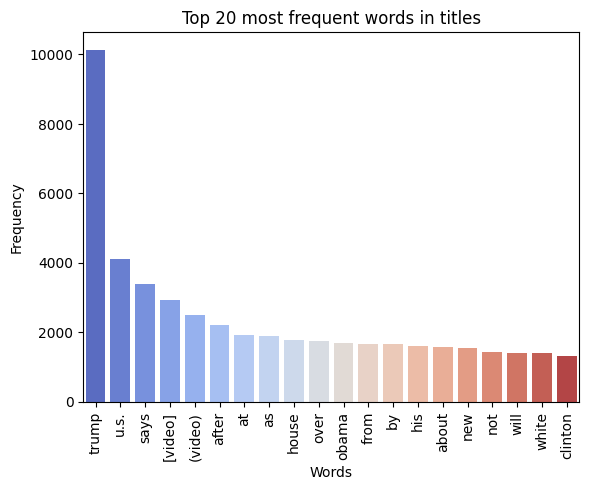

In [18]:
#graph for titles
frequencyPlot(title_frequency, 'titles')

C:\Users\marta\AppData\Local\Temp\ipykernel_11424\3723742698.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=frequency, x='word', y='frequency', palette='coolwarm')


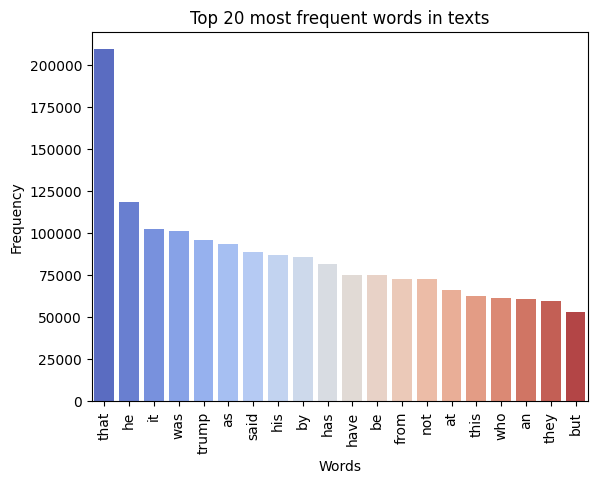

In [19]:
#graph for text
frequencyPlot(text_frequency, 'texts')

In [20]:
#the plots helped to eliminate spam words for better analysis

Feature Extraction - Term Frequency-Inverse Document Frequency and Principal Component Analysis

In [21]:
#Future extraction helps identify words that are more likely to appear in fake or real news articles

In [22]:
#Term Frequency-Inverse Document Frequency - TFIDF - is a method used to measure the importance of a word in a document
#Term Frequency measures how often a word appears in a document by dividing count of word in a document by total words
#Inverse Document Frequency reduces the weight of common words across said documents by taking the logarithm of the divisor of the number 
#of documents by the number of documents with a given word
#Finally to calculate a TFIDF score we have to multiply both TF and IDF parts

In [23]:
#Principal Component Analysis - PCA - reduces the dimensionality of data while preserving as much variance as possible
#by finding directions of maximum variance - called principal components - using eigenvectors of the covariance matrix
#and projecting data onto these components, prioritizing components with the highest variance
#Basically, PCA transforms data into a smaller set of uncorrelated variables - principal components - ranked by variance

In [24]:
#using TFIDF vectorization to transform text data into numerical featrues for further classification
tfidf = TfidfVectorizer(max_features=5000) #limiting the vocabulary to the 5000 most important words based on their TFIDF scores
tfidf_matrix = tfidf.fit_transform(db['text'].fillna('')) #creating a [texts from database, most important words] matrix for next steps

In [25]:
#applying PCA to reduce dimensionality of the TFIDF matrix to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

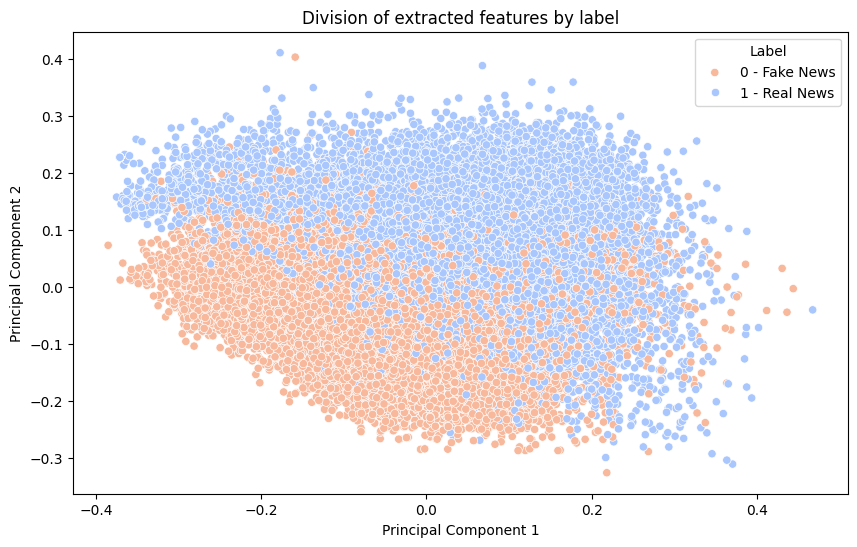

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=db['label'], palette='coolwarm')
plt.title('Division of extracted features by label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label', labels=labels)
plt.show()

In [27]:
#Now we can say that there are words that are most frequent in either fake or real news, which allows us to find them
#and use these key terms as features to build an accurate classification model

Most frequent words in fake news and real articles 

In [28]:
#dividing fake and real news and applying textAnalysis for clearer results
fake_news = db[db['label'] == 0]  
real_news = db[db['label'] == 1]

fake_news_cleaned = fake_news['text'].dropna().apply(textAnalysis)
real_news_cleaned = real_news['text'].dropna().apply(textAnalysis)

In [29]:
#joining the cleaned words back into a single string to match the TfidfVectorizer format
fake_news_joined = fake_news_cleaned.apply(lambda x: ' '.join(x)) 
real_news_joined = real_news_cleaned.apply(lambda x: ' '.join(x)) 

#applying TFIDF
fake_tfidf_matrix = tfidf.transform(fake_news_joined.fillna(''))  
real_tfidf_matrix = tfidf.transform(real_news_joined.fillna(''))  

#summing the TFIDF values for each word in fake and real news to pick the ones with highest scores
fake_word_frequencies = np.asarray(fake_tfidf_matrix.sum(axis=0)).flatten()
real_word_frequencies = np.asarray(real_tfidf_matrix.sum(axis=0)).flatten()

feature_names = np.array(tfidf.get_feature_names_out())

In [30]:
#getting the top 20 most common words for fake and real news
fake_top_words_idx = fake_word_frequencies.argsort()[::-1][:20]
real_top_words_idx = real_word_frequencies.argsort()[::-1][:20]

fake_top_words = feature_names[fake_top_words_idx]
fake_top_frequencies = fake_word_frequencies[fake_top_words_idx]

real_top_words = feature_names[real_top_words_idx]
real_top_frequencies = real_word_frequencies[real_top_words_idx]

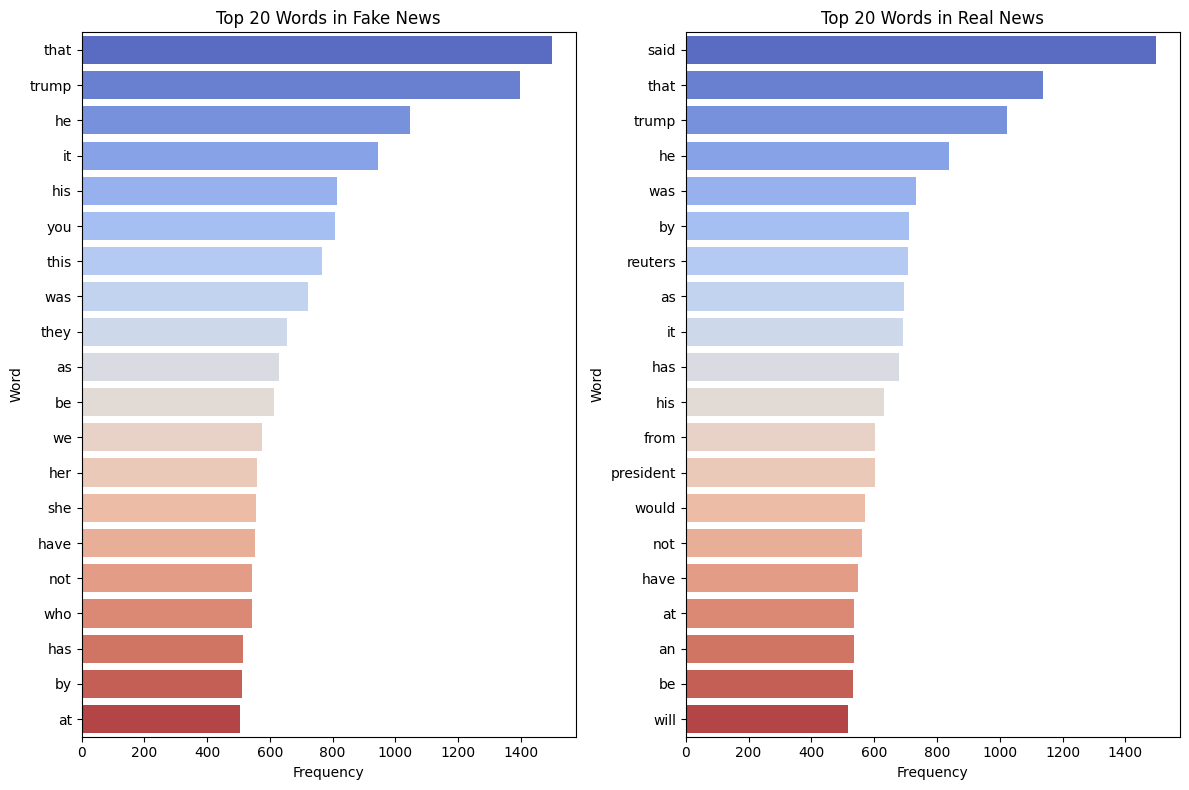

In [31]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.barplot(x=fake_top_frequencies, y=fake_top_words, hue=fake_top_words, palette='coolwarm', legend=False)
plt.title('Top 20 Words in Fake News')
plt.xlabel('Frequency')
plt.ylabel('Word')

plt.subplot(1, 2, 2)
sns.barplot(x=real_top_frequencies, y=real_top_words, hue=real_top_words, palette='coolwarm', legend=False)
plt.title('Top 20 Words in Real News')
plt.xlabel('Frequency')
plt.ylabel('Word')

plt.tight_layout()
plt.show()

In [32]:
#By comparing both graphs we can see the significant differences between most common words in fake and real news
#For example the word with most appearances in real articles is "said" which doesn't even show on the graph for fake news, indecating
#their tendency to quote and report facts, what doesn't happen in the fake news

Co-Occurence frequencies of words in Titles

In [33]:
true_titles = db.loc[db['label'] == 1, 'title'].dropna()

#creating a CountVectorizer to get word pairs (bigrams) from the titles
vectorizer = CountVectorizer(stop_words='english', max_features = 20)  
X = vectorizer.fit_transform(true_titles)

co_occurrence_matrix = (X.T * X)  #matrix multiplication to get co-occurrences
co_occurrence_matrix.setdiag(0)

words = vectorizer.get_feature_names_out()
co_occurrence_df = pd.DataFrame(co_occurrence_matrix.toarray(), index=words, columns=words)

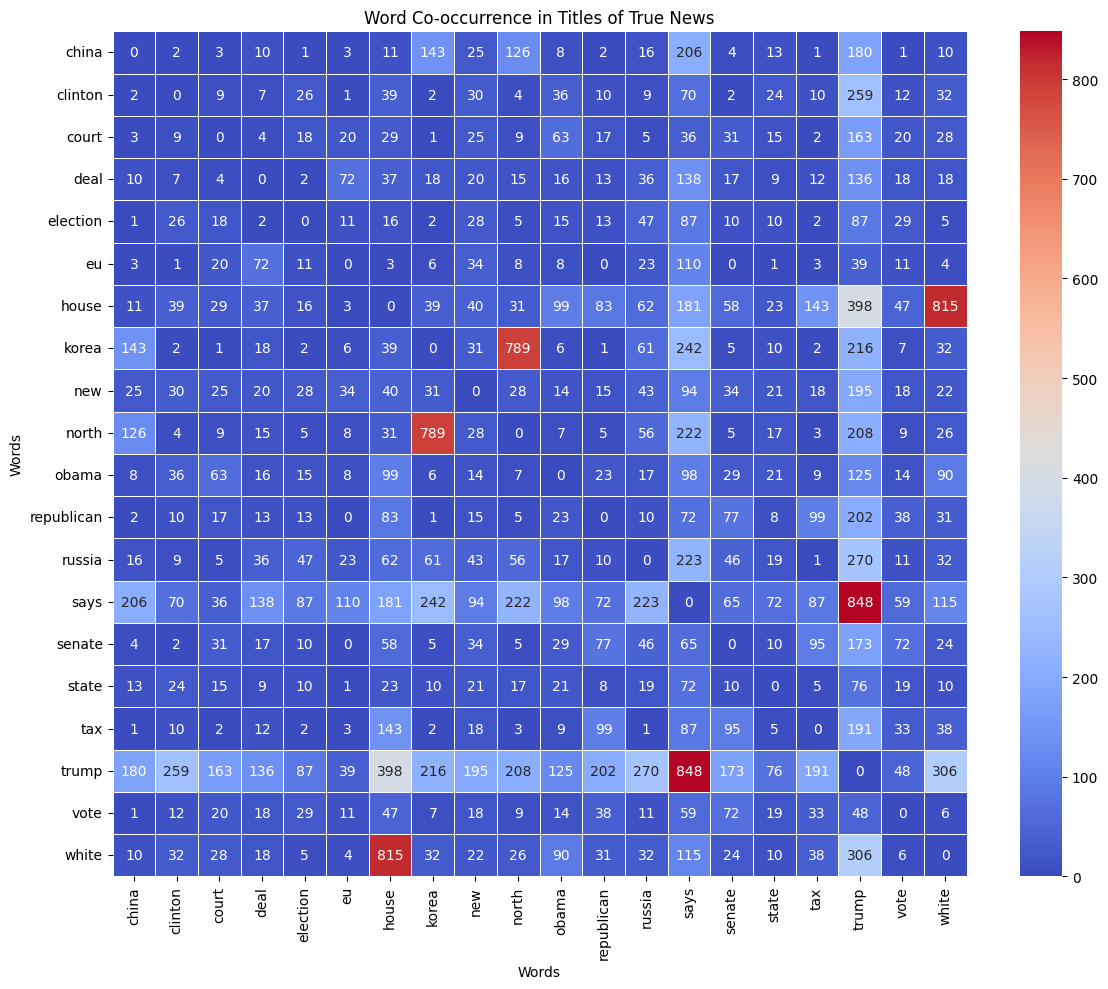

In [34]:
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_df, cmap="coolwarm", annot=True, fmt="d", linewidths=0.5)
plt.title("Word Co-occurrence in Titles of True News")
plt.xlabel("Words")
plt.ylabel("Words")
plt.tight_layout()
plt.show()

In [35]:
#Most popular phrases are "white house", "trump says" and "north korea"

In [36]:
fake_titles = db.loc[db['label'] == 0, 'title'].dropna()

#creating a CountVectorizer to get word pairs (bigrams) from the titles
vectorizer = CountVectorizer(stop_words='english', max_features = 20)  
X = vectorizer.fit_transform(fake_titles)

co_occurrence_matrix = (X.T * X)  #matrix multiplication to get co-occurrences
co_occurrence_matrix.setdiag(0)

words = vectorizer.get_feature_names_out()
co_occurrence_df = pd.DataFrame(co_occurrence_matrix.toarray(), index=words, columns=words)

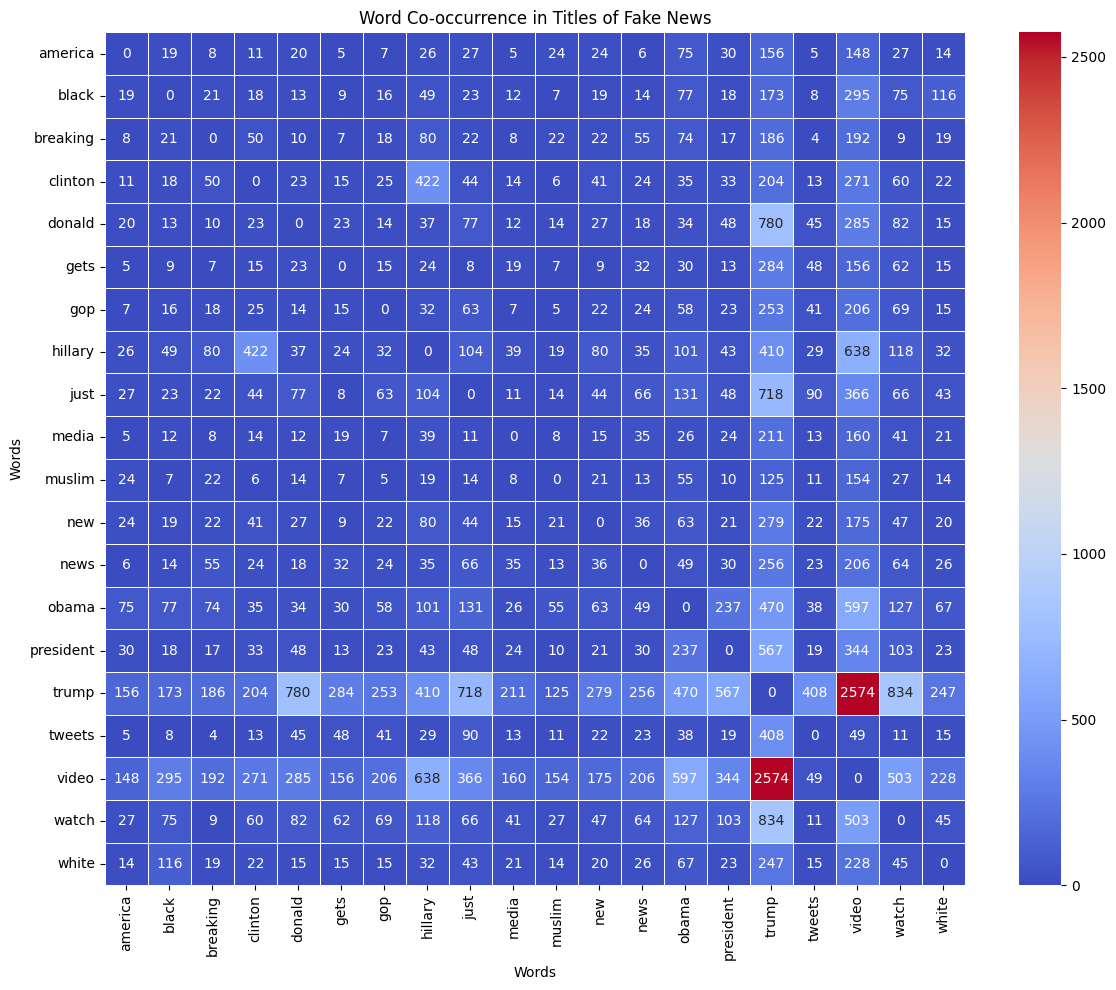

In [37]:
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_df, cmap="coolwarm", annot=True, fmt="d", linewidths=0.5)
plt.title("Word Co-occurrence in Titles of Fake News")
plt.xlabel("Words")
plt.ylabel("Words")
plt.tight_layout()
plt.show()

In [38]:
#Most popular phrase is "video trump"

In [39]:
#The majority of fake news is about Trump, while real news concern other issues, for example  North Korea, White House

Classifications

In [ ]:
#separate features: 'text', 'title', and the target: 'label'
X_text = db['text']
X_title = db['title']
y = db['label']

#apply TF-IDF transformation on 'text' and 'title' separately
tfidf_text = TfidfVectorizer(max_features=5000)  #limit vocabulary size for 'text'
tfidf_title = TfidfVectorizer(max_features=400)  #smaller vocabulary size for 'title'

#convert text/title into TF-IDF feature matrices
X_text_tfidf = tfidf_text.fit_transform(X_text.fillna(''))
X_title_tfidf = tfidf_title.fit_transform(X_title.fillna(''))

#combine the two feature matrices (text + title) into a single dataframe
X = pd.concat([pd.DataFrame(X_text_tfidf.toarray()), pd.DataFrame(X_title_tfidf.toarray())], axis=1)

#split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

K-Nearest Neighbors (KNN) algorithm

In [ ]:
#K-Nearest Neighbors - KNN - is a simple algorithm used for classification where each data point is represented as a feature vector in a multi-dimensional space
#When predicting the label for a new instance, KNN computes the distance between this distance and all the data points in the training set
#The algorithm identifies the k nearest data points - neighbors - to the new instance based on the calculated distances and the labels of the k neighbors are examined
#The algorithm assigns the label that appears most frequently among the k neighbors to the new instance - majority voting

In [42]:
k_values = list(range(1, 11))  #testing K from 1 to 10
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred_knn)
    accuracies.append(acc)
    print(f"k = {k}, accuracy = {acc:.4f}")

k = 1, accuracy = 0.8379
k = 2, accuracy = 0.8567
k = 3, accuracy = 0.8692
k = 4, accuracy = 0.8740
k = 5, accuracy = 0.8767
k = 6, accuracy = 0.8808
k = 7, accuracy = 0.8820
k = 8, accuracy = 0.8837
k = 9, accuracy = 0.8864
k = 10, accuracy = 0.8893


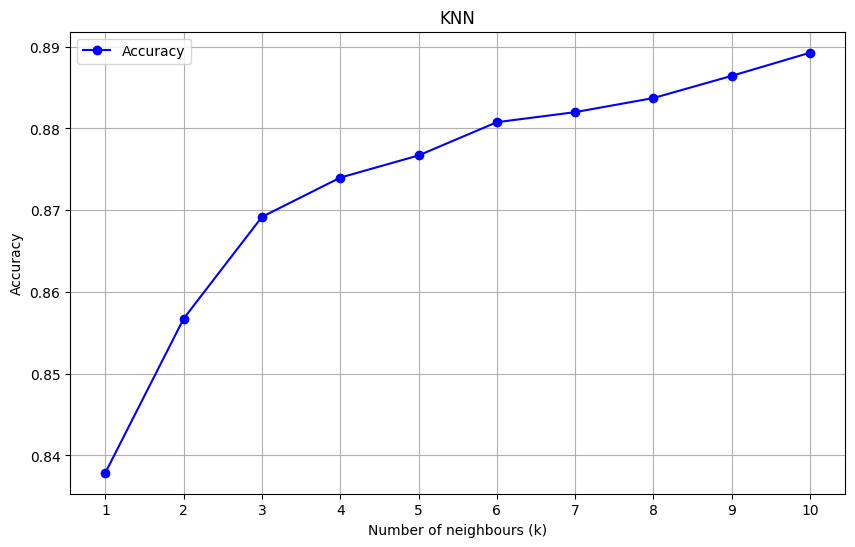

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', label="Accuracy")
plt.title("KNN")
plt.xlabel("Number of neighbours (k)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.legend()
plt.grid()
plt.show()

In [44]:
#Creating a plot to find the best value of k
#A small k can lead to overfitting - sensitive to noise - while a large k might lead to underfitting - too generalized

In [ ]:
chosen_k = 3

#retrain the KNN model using the chosen k value
knn = KNeighborsClassifier(n_neighbors=chosen_k)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("\nFinal KNN Results:")
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


Final KNN Results:
KNN Accuracy: 0.8691796008869179
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3725
           1       0.86      0.91      0.88      4393

    accuracy                           0.87      8118
   macro avg       0.87      0.87      0.87      8118
weighted avg       0.87      0.87      0.87      8118



Multi-Layer Perceptron (MLP) model with hyperparameter optimization

In [46]:
#Multilayer Perceptron - MLP - is a type of feedforward artificial neural network used for classification, which consists of 
#multiple layers of neurons
#Input Layer receives the input features
#Hidden Layers where computations and activations occur to learn patterns from the data through weighted connectiond
#Output Layer produces the final predictions

In [87]:
def build_model(hp): #builds a parameterized MLP model for binary classification
    model = Sequential()
    model.add(Dense(
        units=hp.Choice('units_layer_1', [32, 64]), #number of neurons
        activation=hp.Choice('activation_layer_1', ['relu', 'tanh']), #activation functions
        input_shape=(X_train.shape[1],) 
    ))
    
    #additional hidden layers (up to 3 hidden layers)
    for i in range(hp.Int('num_hidden_layers', 1, 3)):
        model.add(Dense(
            units=hp.Choice(f'units_layer_{i+2}', [32, 64]),
            activation=hp.Choice(f'activation_layer_{i+2}', ['relu', 'tanh']),
        ))

    model.add(Dense(1, activation='sigmoid')) #sigmoid for binary classification

    #compile the model with different optimizers
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy', 'mae']
    )
    
    return model

In [ ]:
tuner = kt.GridSearch(
    hypermodel=build_model,             #function to build the model
    objective='val_accuracy',           #optimize for validation accuracy
    max_trials=100,                     #maximum combinations of hyperparameters to test
    executions_per_trial=2,             #number of times each model is evaluated for stability
    directory='hyperparameter_search',
    project_name='grid_search_mlp')             

c:\Users\marta\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
tuner.search(X_train, y_train, 
             validation_data=(X_test, y_test),
             epochs=5,                         #train for 5 epochs per trial
             batch_size=32,                    #batch size of 32 for efficient training
             verbose=1)                        #show progress of tuning

Trial 30 Complete [00h 01m 24s]
val_accuracy: 0.976410448551178

Best val_accuracy So Far: 0.9773959219455719
Total elapsed time: 00h 29m 26s


In [82]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(best_hps.values)

Best hyperparameters:
{'units_layer_1': 32, 'activation_layer_1': 'relu', 'num_hidden_layers': 3, 'units_layer_2': 64, 'optimizer': 'adam', 'units_layer_3': 32, 'units_layer_4': 32}


In [83]:
#train the best model with early stopping

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train, 
    validation_split=0.1, 
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

test_loss, test_accuracy, test_mae = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test MAE: {test_mae}")

c:\Users\marta\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9276 - loss: 0.2074 - mae: 0.1375 - val_accuracy: 0.9741 - val_loss: 0.0783 - val_mae: 0.0409
Epoch 2/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9873 - loss: 0.0356 - mae: 0.0204 - val_accuracy: 0.9754 - val_loss: 0.0764 - val_mae: 0.0296
Epoch 3/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9936 - loss: 0.0165 - mae: 0.0099 - val_accuracy: 0.9763 - val_loss: 0.0967 - val_mae: 0.0259
Epoch 4/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9975 - loss: 0.0073 - mae: 0.0047 - val_accuracy: 0.9744 - val_loss: 0.1108 - val_mae: 0.0271
Epoch 5/10
914/914 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9982 - loss: 0.0053 - mae: 0.0029 - val_accuracy: 0.9707 - val_loss: 0.1342 - val_mae: 0.0301
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9735 - loss: 0.1229 - mae: 0.0274
Test Loss: 0.1256788671016693
Test Accuracy: 0.9742547273635864
Test MAE: 0.026707801967859268


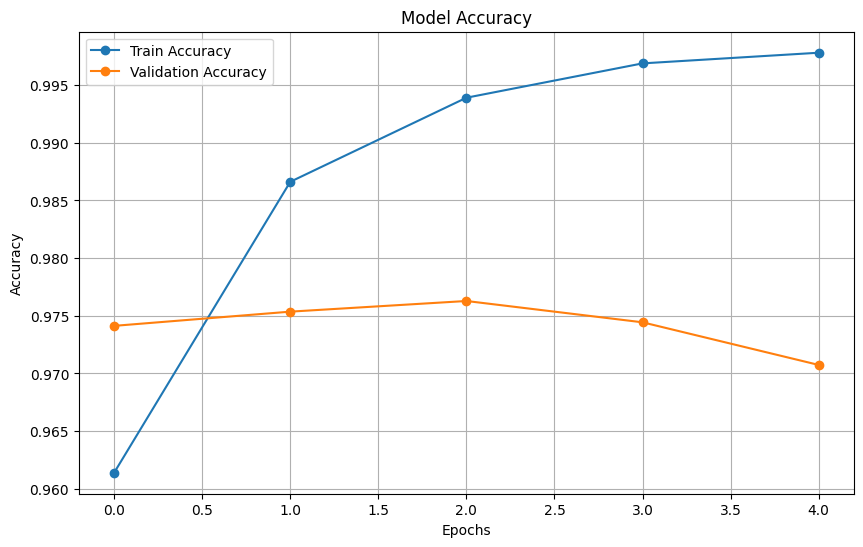

In [84]:
#plot the training and validation accuracy

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

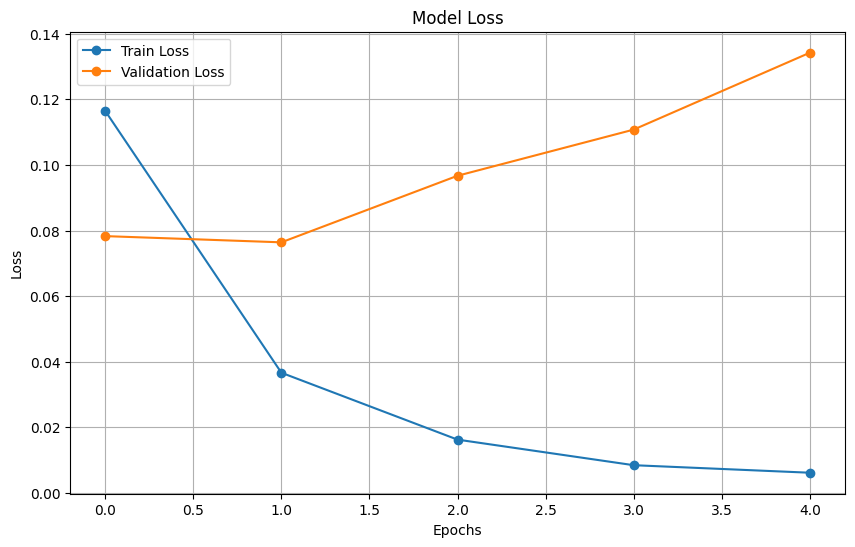

In [85]:
#plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

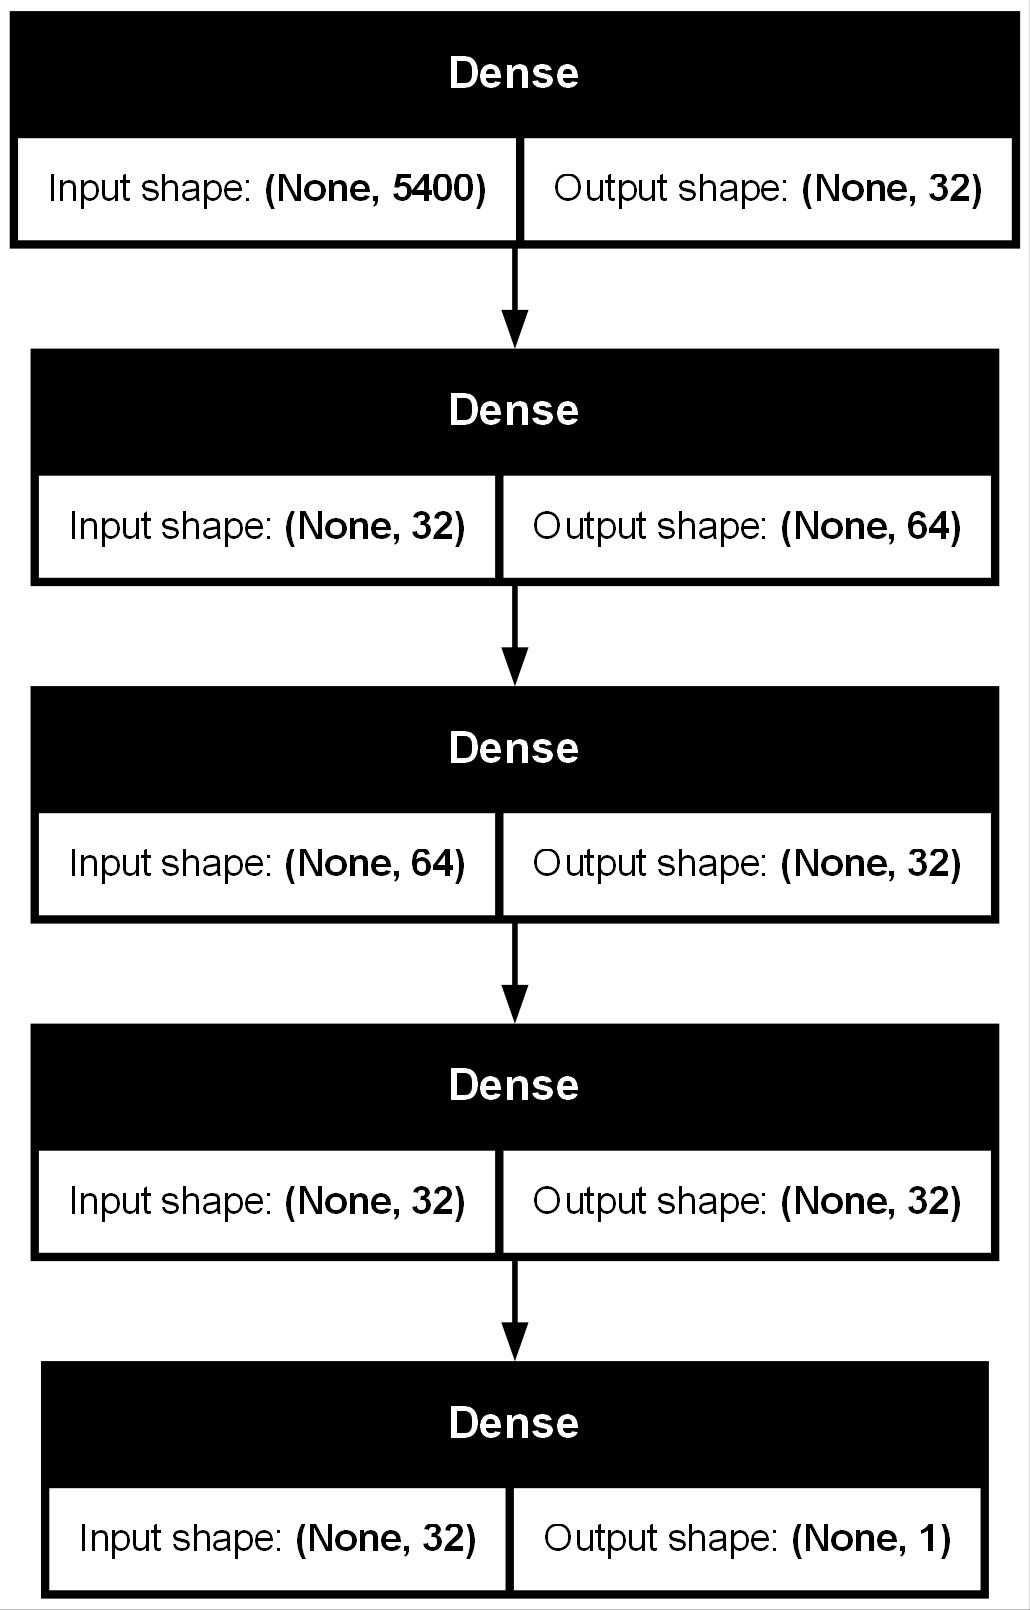

In [86]:
#with import of tensorflow
tf.keras.utils.plot_model(best_model, show_shapes = True, to_file = 'model_mlp.jpg')